# Importing the Libraries

In [1]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

# Data Preparation

In [2]:
from datasets import load_dataset

ds = load_dataset("Saugatkafley/Nepali-Roman-Transliteration")

C:\Users\ASUS\anaconda3\envs\gpu_usage\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['unique_identifier', 'native word', 'english word'],
        num_rows: 2397414
    })
    validation: Dataset({
        features: ['unique_identifier', 'native word', 'english word'],
        num_rows: 2804
    })
})

In [4]:
train = pd.DataFrame(ds["train"][:200000])
train.head()

,unique_identifier,native word,english word
0,nep1,मुस्कुराउँदै,muskuraundai
1,nep2,मान्दछन्,mandachhan
2,nep3,भएझैं,bhaejhain
3,nep4,हराउँछ,haraaunchha
4,nep5,मुन्टो,munto


In [5]:
train['native word'] = train['native word'].astype(str)
train['english word'] = train['english word'].astype(str)

In [6]:
train['native word'] = train['native word'].str.strip() # nepali has no caps
train['english word'] = train['english word'].str.strip().str.lower()

In [7]:
train = train[~train['english word'].str.contains('\.')]
train = train[~train['english word'].str.contains(',')]

In [8]:
train.head()

,unique_identifier,native word,english word
0,nep1,मुस्कुराउँदै,muskuraundai
1,nep2,मान्दछन्,mandachhan
2,nep3,भएझैं,bhaejhain
3,nep4,हराउँछ,haraaunchha
4,nep5,मुन्टो,munto


In [9]:
def isEnglish(s):
  try:
      s.encode(encoding='utf-8').decode('ascii')
  except UnicodeDecodeError:
      return False
  else:
      return True

train = train[train['english word'].apply(isEnglish)]

In [10]:
sos = '^'
eos = '$'

train['english word'] = sos + train['english word'].astype(str) + eos

train.head()

,unique_identifier,native word,english word
0,nep1,मुस्कुराउँदै,^muskuraundai$
1,nep2,मान्दछन्,^mandachhan$
2,nep3,भएझैं,^bhaejhain$
3,nep4,हराउँछ,^haraaunchha$
4,nep5,मुन्टो,^munto$


In [11]:
nepali_text = train['native word']
english_text = train['english word']

In [12]:
print('nepali text shape :',nepali_text.shape)
print(nepali_text[0])
print('english text shape :',english_text.shape)
print(english_text[0])

nepali text shape : (200000,)
मुस्कुराउँदै
english text shape : (200000,)
^muskuraundai$


In [13]:
train_nepali_text, val_nepali_text, train_english_text, val_english_text = train_test_split(nepali_text, english_text, test_size=0.2, random_state=42)

In [14]:
max_input_len = max([len(text) for text in nepali_text])
print(max_input_len)
max_target_len = max([len(text) for text in english_text])
print(max_target_len)

19
29


In [15]:
input_chars = sorted(list(set(''.join(nepali_text))))
print(input_chars)
target_chars = sorted(list(set(''.join(english_text))))
print(target_chars)

['ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्', '॰']
['$', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [16]:
num_encoder_tokens = len(input_chars)
print(num_encoder_tokens)
num_decoder_tokens = len(target_chars)
print(num_decoder_tokens)

63
28


In [17]:
input_char_index = dict((char, i) for i, char in enumerate(input_chars))
print(input_char_index)
target_char_index = dict((char, i) for i, char in enumerate(target_chars))
print(target_char_index)

{'ँ': 0, 'ं': 1, 'ः': 2, 'अ': 3, 'आ': 4, 'इ': 5, 'ई': 6, 'उ': 7, 'ऊ': 8, 'ऋ': 9, 'ए': 10, 'ऐ': 11, 'ऑ': 12, 'ओ': 13, 'औ': 14, 'क': 15, 'ख': 16, 'ग': 17, 'घ': 18, 'ङ': 19, 'च': 20, 'छ': 21, 'ज': 22, 'झ': 23, 'ञ': 24, 'ट': 25, 'ठ': 26, 'ड': 27, 'ढ': 28, 'ण': 29, 'त': 30, 'थ': 31, 'द': 32, 'ध': 33, 'न': 34, 'प': 35, 'फ': 36, 'ब': 37, 'भ': 38, 'म': 39, 'य': 40, 'र': 41, 'ल': 42, 'व': 43, 'श': 44, 'ष': 45, 'स': 46, 'ह': 47, '़': 48, 'ऽ': 49, 'ा': 50, 'ि': 51, 'ी': 52, 'ु': 53, 'ू': 54, 'ृ': 55, 'े': 56, 'ै': 57, 'ॉ': 58, 'ो': 59, 'ौ': 60, '्': 61, '॰': 62}
{'$': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


In [18]:
encoder_input_data = np.zeros((len(train_nepali_text), max_input_len, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [19]:
for i, (input_text, target_text) in enumerate(zip(train_nepali_text, train_english_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_char_index[char]] = 1

# Defining The Model

In [20]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Training

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
model_save_filename = "models/model.h5"
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=7,
    restore_best_weights=True
)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 63)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 28)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        327680      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [23]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=20,
          validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/20
1994/2000 [============================>.] - ETA: 0s - loss: 0.8710 - accuracy: 0.1536
Epoch 1: val_accuracy improved from -inf to 0.23427, saving model to models\model.h5
2000/2000 [==============================] - 26s 11ms/step - loss: 0.8701 - accuracy: 0.1538 - val_loss: 0.5682 - val_accuracy: 0.2343
Epoch 2/20
2000/2000 [==============================] - ETA: 0s - loss: 0.4481 - accuracy: 0.2729
Epoch 2: val_accuracy improved from 0.23427 to 0.29577, saving model to models\model.h5
2000/2000 [==============================] - 21s 10ms/step - loss: 0.4481 - accuracy: 0.2729 - val_loss: 0.3687 - val_accuracy: 0.2958
Epoch 3/20
1997/2000 [============================>.] - ETA: 0s - loss: 0.3541 - accuracy: 0.3034
Epoch 3: val_accuracy did not improve from 0.29577
2000/2000 [==============================] - 22s 11ms/step - loss: 0.3542 - accuracy: 0.3034 - val_loss: 0.4907 - val_accuracy: 0.2594
Epoch 4/20
2000/2000 [==============================] - ETA: 0s - loss: 0.309

In [24]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


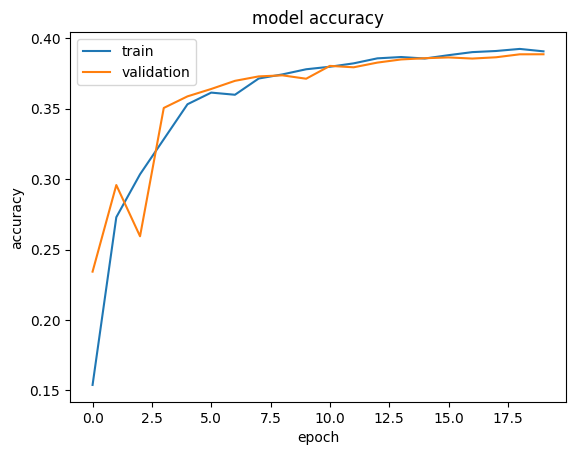

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

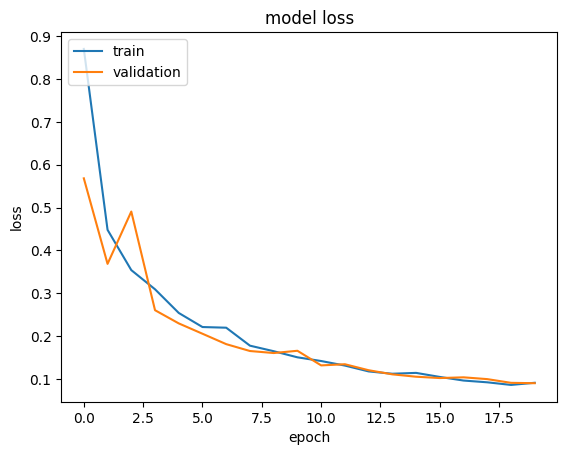

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model Inference

In [159]:
from keras.models import load_model
import numpy as np

# Define constants
num_encoder_tokens = 63
num_decoder_tokens = 28
max_input_len = 19
max_target_len = 31
input_char_index = {'ँ': 0, 'ं': 1, 'ः': 2, 'अ': 3, 'आ': 4, 'इ': 5, 'ई': 6, 'उ': 7, 'ऊ': 8, 'ऋ': 9, 'ए': 10, 'ऐ': 11, 'ऑ': 12, 'ओ': 13, 'औ': 14, 'क': 15, 'ख': 16, 'ग': 17, 'घ': 18, 'ङ': 19, 'च': 20, 'छ': 21, 'ज': 22, 'झ': 23, 'ञ': 24, 'ट': 25, 'ठ': 26, 'ड': 27, 'ढ': 28, 'ण': 29, 'त': 30, 'थ': 31, 'द': 32, 'ध': 33, 'न': 34, 'प': 35, 'फ': 36, 'ब': 37, 'भ': 38, 'म': 39, 'य': 40, 'र': 41, 'ल': 42, 'व': 43, 'श': 44, 'ष': 45, 'स': 46, 'ह': 47, '़': 48, 'ऽ': 49, 'ा': 50, 'ि': 51, 'ी': 52, 'ु': 53, 'ू': 54, 'ृ': 55, 'े': 56, 'ै': 57, 'ॉ': 58, 'ो': 59, 'ौ': 60, '्': 61, '॰': 62}
target_char_index = {'$': 0, '^': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}

target_chars = list(target_char_index.keys())

# Load the trained model
model = load_model('models/model_130.h5')

# Extract encoder and decoder models
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.get_layer('lstm').output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]
decoder_lstm = model.get_layer('lstm_1')
decoder_dense = model.get_layer('dense')

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Decode sequence function remains the same
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_index['^']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_chars[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '$' or len(decoded_sentence) > max_target_len):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

# Predict output function remains the same
def predict_output(input_text):
    words = input_text.split(' ')
    transliterated_words = []
    for word in words:
        input_seq = np.zeros((1, max_input_len, num_encoder_tokens), dtype='float32')
        for t, char in enumerate(word):
            input_seq[0, t, input_char_index[char]] = 1
        decoded_word = decode_sequence(input_seq)
        transliterated_words.append(decoded_word.rstrip('$'))
    return ' '.join(transliterated_words)

# Test the prediction
text = 'मेरो नाम निका महर्जन हो'
print('Nepali text:', text)
print('Transliterated English text:', predict_output(text))


Nepali text: मेरो नाम निका महर्जन हो
1/1 [==============================] - 0s 22ms/step
Transliterated English text: mero nama nika maharjan ho
